In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork

In [51]:
TAU = 0.4 / (256)
X_BAR = jnp.log(0.16)
KAPPA = 12 # revert in a month
SIGMA_SIGMA = 6.4
RHO = -0.05

## Skew Stoch Vol State Space Functions

In [52]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def skew_g_from_total_noise(prev_particle, particle, noise):
    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    return skew_total_mean + noise * jnp.sqrt(skew_total_var)

In [53]:
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def skew_observation_weight_single(particle, prev_particle, Y_array, idt):

    # Mean reversion term: E[X_t | X_{t-1}] = X_{t-1} + κτ(X̄ - X_{t-1})
    mean_reversion_term = prev_particle + KAPPA * TAU * (X_BAR - prev_particle)

    # Skew-normal distribution parameters for Y[t]
    # Mean: μ_Y = -0.5τ exp(2X_t) + ρ(exp(X_t)/σ²)(X_t - E[X_t | X_{t-1}])
    skew_total_mean = -0.5 * TAU * jnp.exp(2 * particle) + RHO  * (jnp.exp(particle) / SIGMA_SIGMA) * (particle - mean_reversion_term)
    
    # Variance: σ²_Y = τ exp(2X_t)(1 - ρ²)
    skew_total_var = TAU * jnp.exp(2 * particle) * (1 - RHO**2)

    # Return log-likelihood: log P(Y[idt] | X_t, X_{t-1})
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), skew_total_mean, jnp.sqrt(skew_total_var))



# Experiments

Show:
- Better ESS with NN method. 
- No improvment in forecasting. 

# Experiment 1

In [54]:
TRAIN_KEY = jax.random.key(112)
DATA_KEY = jax.random.key(72)
EVAL_KEY = jax.random.key(80)
INIT_PARTICLE_KEY = jax.random.key(16)

In [55]:
skew_vol_vehicle = PFVehicle(f_from_noise, skew_g_from_total_noise, f_likelihood_single, skew_observation_weight_single)

skew_bootstrap_pf = ParticleFilter(f_sample_fn, skew_observation_weight_single)


  0%|          | 0/1000 [00:00<?, ?it/s]

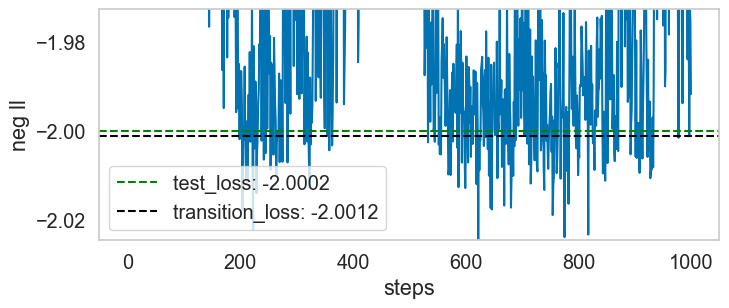

In [56]:
def transition_model(input):
    last_x, y = input
    mean = last_x + TAU * KAPPA * (X_BAR - last_x)
    scale = jnp.sqrt(TAU) * SIGMA_SIGMA
    return mean, scale

initial_model = FeedForwardNetwork(1, 64, jax.random.key(72))
skew_vol_vehicle.train_model(
    TRAIN_KEY, 
    initial_model,
    5000, 
    steps = 1000, 
    learning_rate=0.01,
    X_bar = X_BAR,
    transition_model=transition_model
)

In [57]:
N_RUNS = 5
N_TIMESTEPS = 1000
N_PARTICLES = 2500

DATA_KEY = jax.random.key(65)
EVAL_KEY = jax.random.key(56)

print(f"Generating {N_RUNS} runs of data with {N_TIMESTEPS} timesteps each...")
# 1. Use the stochastic volatility vehicle to generate batched data 

x_vals, y_vals = skew_vol_vehicle.generate_data(
    DATA_KEY, 
    N_RUNS,
    N_TIMESTEPS,
    X_BAR
)
print("Data generation complete.")
print(f"x_vals shape: {x_vals.shape}, y_vals shape: {y_vals.shape}")

INIT_PARTICLE_KEY = jax.random.key(16)
initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (N_PARTICLES,)) * 0.1 + X_BAR
initial_log_weights = jnp.zeros(N_PARTICLES) - jnp.log(N_PARTICLES)
print(f"Initial particles and log weights prepared. Shape: {initial_particles.shape}")

# 2. Use vmap to get the results for both particle filters. 
a_key, b_key = jax.random.split(EVAL_KEY, 2)

print("Running bootstrap particle filter simulations...")
_, _, bootstrap_diagnostics = jax.vmap(skew_bootstrap_pf.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(a_key, N_RUNS), 
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)
print("Bootstrap particle filter simulations complete.")

print("Running NN particle filter simulations...")
nn_particle_filter = skew_vol_vehicle.build_NN_particle_filter(N_PARTICLES = N_PARTICLES)
_, _, nn_diagnostics = jax.vmap(nn_particle_filter.simulate, in_axes=(0, None, None, 0, 0))(
    jax.random.split(b_key, N_RUNS),
    initial_particles, 
    initial_log_weights, 
    y_vals, 
    x_vals
)
print("NN particle filter simulations complete.")

Generating 5 runs of data with 1000 timesteps each...
Data generation complete.
x_vals shape: (5, 1000), y_vals shape: (5, 1000)
Initial particles and log weights prepared. Shape: (2500,)
Running bootstrap particle filter simulations...
Bootstrap particle filter simulations complete.
Running NN particle filter simulations...
NN particle filter simulations complete.


In [58]:
from pprint import pprint 

pprint(nn_diagnostics['ess'] - bootstrap_diagnostics['ess'])
pprint(bootstrap_diagnostics['ess'])


Array([[-149.42505 , -235.54395 , -268.94043 , ..., -330.02087 ,
         589.55005 ,  455.9674  ],
       [-116.895996, -209.78076 , -240.12231 , ...,  620.87573 ,
         433.93115 ,  160.08789 ],
       [-210.8335  , -352.77856 , -426.07227 , ...,   87.58826 ,
         181.15979 , -608.4927  ],
       [-139.95435 , -239.24365 , -285.9038  , ...,  -98.10962 ,
        -201.3169  , -240.9602  ],
       [-137.01294 , -375.80078 , -411.5786  , ..., -416.14648 ,
        -669.8987  ,  486.36377 ]], dtype=float32)
Array([[2484.89  , 2451.5676, 2376.1191, ..., 1515.2383, 1483.6526,
        1466.6997],
       [2492.587 , 2447.0605, 2359.8225, ..., 1687.8567, 1676.7009,
        1648.76  ],
       [2477.0972, 2481.0857, 2477.2378, ..., 1977.267 , 1696.2712,
        2161.591 ],
       [2472.0505, 2390.7756, 2310.3083, ..., 1891.1871, 1857.4971,
        1841.0312],
       [2471.222 , 2474.4092, 2448.2148, ..., 2470.8792, 1765.8282,
        1661.052 ]], dtype=float32)


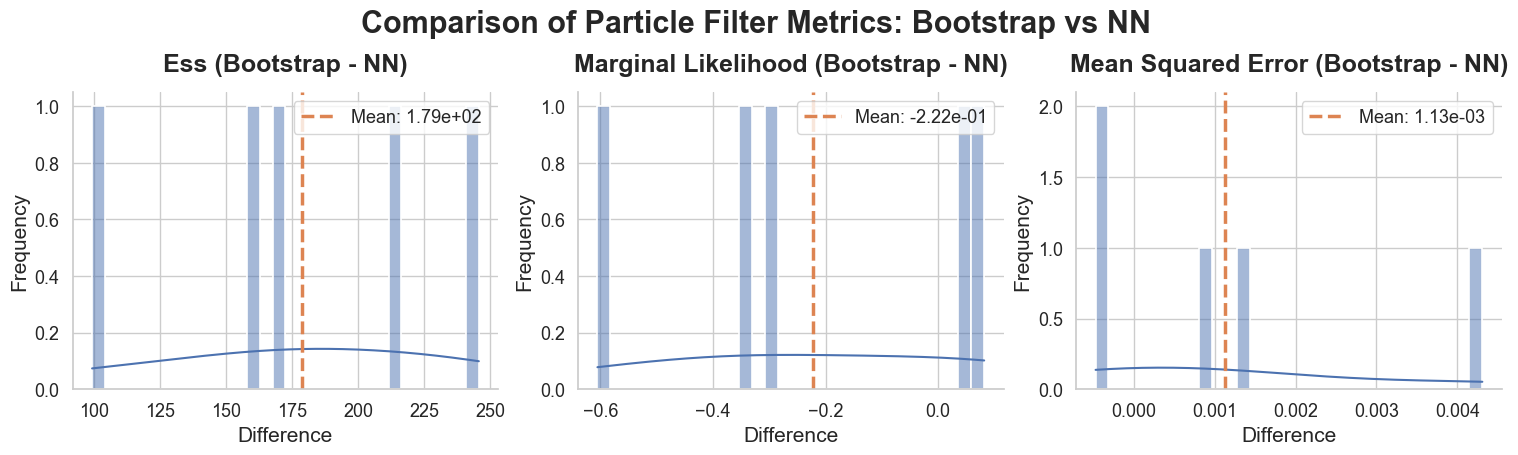

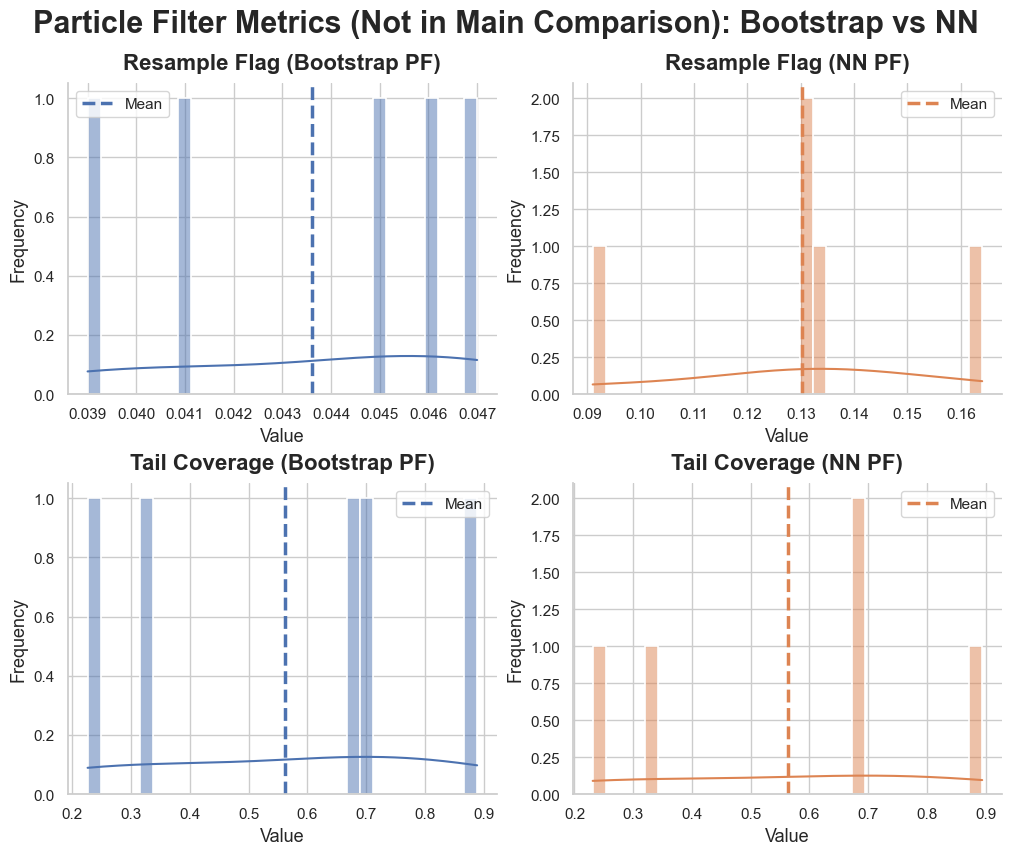

In [59]:
# Plot and compare relevant particle filter metrics for the stochastic volatility experiment.

import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to compare between Optimal and NN particle filters
comparison_metrics = ['ess', 'marginal_likelihood', 'mean_squared_error']

# Compute the difference in mean metric values (Optimal PF - NN PF) across runs
comparison_results = {
    metric: jnp.mean(bootstrap_diagnostics[metric], axis=1) - jnp.mean(nn_diagnostics[metric], axis=1)
    for metric in comparison_metrics
}

# Plot histograms of the differences for each metric
sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")
fig, axes = plt.subplots(1, len(comparison_results), figsize=(5 * len(comparison_results), 4), constrained_layout=True)

if len(comparison_results) == 1:
    axes = [axes]

for ax, (metric, diff_vals) in zip(axes, comparison_results.items()):
    diff_np = jnp.asarray(diff_vals).flatten()
    mean_diff = float(jnp.mean(diff_np))
    sns.histplot(diff_np, bins=30, kde=True, ax=ax, color="#4C72B0", edgecolor="white", linewidth=1.2)
    ax.axvline(mean_diff, color="#DD8452", linestyle="--", linewidth=2.5, label=f"Mean: {mean_diff:.2e}")
    ax.set_title(f"{metric.replace('_', ' ').title()} (Bootstrap - NN)", fontsize=18, weight='bold', pad=15)
    ax.set_xlabel("Difference", fontsize=15)
    ax.set_ylabel("Frequency", fontsize=15)
    ax.legend(fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Comparison of Particle Filter Metrics: Bootstrap vs NN", fontsize=22, weight='bold', y=1.1)
plt.show()

not_in_comparison = ['resample_flag', 'tail_coverage']

# Set the plotting theme for consistency and clarity
sns.set_theme(style="whitegrid", font_scale=1.3, palette="colorblind")

# Determine the number of metrics to plot
n_metrics = len(not_in_comparison)

# Create a figure with two columns: one for Bootstrap PF, one for NN PF
fig, axes = plt.subplots(
    n_metrics, 2, figsize=(10, 4 * n_metrics), constrained_layout=True
)

# Ensure axes is always 2D for consistent indexing
if n_metrics == 1:
    axes = axes.reshape(1, 2)

for i, metric in enumerate(not_in_comparison):
    # Compute the mean of the metric across the appropriate axis for both filters
    bootstrap_vals = jnp.mean(bootstrap_diagnostics[metric], axis=1)
    nn_vals = jnp.mean(nn_diagnostics[metric], axis=1)

    # Convert JAX arrays to numpy arrays for plotting
    bootstrap_vals_np = jnp.asarray(bootstrap_vals).flatten()
    nn_vals_np = jnp.asarray(nn_vals).flatten()

    # Plot histogram for Bootstrap Particle Filter
    ax_bootstrap = axes[i, 0]
    sns.histplot(
        bootstrap_vals_np, bins=30, kde=True, ax=ax_bootstrap,
        color="#4C72B0", edgecolor="white", linewidth=1.2
    )
    mean_bootstrap = float(jnp.mean(bootstrap_vals_np))
    ax_bootstrap.axvline(mean_bootstrap, color="#4C72B0", linestyle="--", linewidth=2.5, label="Mean")
    ax_bootstrap.set_title(
        f"{metric.replace('_', ' ').title()} (Bootstrap PF)",
        fontsize=16, weight='bold', pad=10
    )
    ax_bootstrap.set_xlabel("Value", fontsize=13)
    ax_bootstrap.set_ylabel("Frequency", fontsize=13)
    ax_bootstrap.legend(fontsize=11)
    ax_bootstrap.tick_params(axis='both', which='major', labelsize=11)
    ax_bootstrap.spines['top'].set_visible(False)
    ax_bootstrap.spines['right'].set_visible(False)

    # Plot histogram for Neural Network Particle Filter
    ax_nn = axes[i, 1]
    sns.histplot(
        nn_vals_np, bins=30, kde=True, ax=ax_nn,
        color="#DD8452", edgecolor="white", linewidth=1.2
    )
    mean_nn = float(jnp.mean(nn_vals_np))
    ax_nn.axvline(mean_nn, color="#DD8452", linestyle="--", linewidth=2.5, label="Mean")
    ax_nn.set_title(
        f"{metric.replace('_', ' ').title()} (NN PF)",
        fontsize=16, weight='bold', pad=10
    )
    ax_nn.set_xlabel("Value", fontsize=13)
    ax_nn.set_ylabel("Frequency", fontsize=13)
    ax_nn.legend(fontsize=11)
    ax_nn.tick_params(axis='both', which='major', labelsize=11)
    ax_nn.spines['top'].set_visible(False)
    ax_nn.spines['right'].set_visible(False)

plt.suptitle(
    "Particle Filter Metrics (Not in Main Comparison): Bootstrap vs NN",
    fontsize=22, weight='bold', y=1.05
)
plt.show()